In [1]:
import shutil
import os

# Define source and destination paths
source_dir = '/kaggle/input/tensorflow-graphics/keras/default/1'
dest_dir = '/kaggle/working/graphic'

# Move the directory to a writable location
shutil.copytree(source_dir, dest_dir)

# Change to the new directory
os.chdir(dest_dir)

print(os.listdir(dest_dir))


['.gitignore', '.bazelrc', '.github', 'LICENSE', 'requirements.unix', 'requirements.txt', '.flake8', 'submodules', '.pylintrc', 'MANIFEST.in', 'WORKSPACE', 'README.md', '.gitmodules', 'CONTRIBUTING.md', 'pytest.ini', 'tensorflow_graphics', 'setup.py']


In [2]:
# Install the package
!pip install .

Processing /kaggle/working/graphic
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.1/700.1 kB 22.5 MB/s eta 0:00:00
  Created wheel for tensorflow-graphics: filename=tensorflow_graphics-2024.9.7-py3-none-any.whl size=466642 sha256=dddad1d24a782b8011a85220d0715b7831dd371b531a5b9084fba8a18fee43cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-vuv2is06/wheels/3d/98/4f/27027e2cc0d727c70e3c91e26a870fd7eb53e8bb61811a43ef
Successfully built tensorflow-graphics
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflic

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow_graphics.projects.neural_voxel_renderer import helpers
from tensorflow_graphics.projects.neural_voxel_renderer import models
from tensorflow_graphics.rendering.volumetric import visual_hull

In [4]:
!rm -f /tmp/example_data.p*
!wget -P /tmp/ https://storage.googleapis.com/tensorflow-graphics/notebooks/neural_voxel_renderer/example_data.p

with open('/tmp/example_data.p', 'rb') as f:
  example_data = pickle.load(f)

object_voxels = example_data['object_voxels']
camera_rotation_matrix = example_data['camera_rotation_matrix']
camera_translation_vector = example_data['camera_translation_vector']
focal = example_data['focal']
principal_point = example_data['principal_point']
light_position = example_data['light_position']
object_rotation = example_data['object_rotation']
object_translation = example_data['object_translation']
object_elevation = example_data['object_elevation'] 

--2024-09-07 22:44:18--  https://storage.googleapis.com/tensorflow-graphics/notebooks/neural_voxel_renderer/example_data.p
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.207, 142.251.18.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335545823 (320M) [text/x-pascal]
Saving to: '/tmp/example_data.p'

example_data.p      100%[===================>] 320.00M  41.0MB/s    in 8.5s    

2024-09-07 22:44:26 (37.8 MB/s) - '/tmp/example_data.p' saved [335545823/335545823]



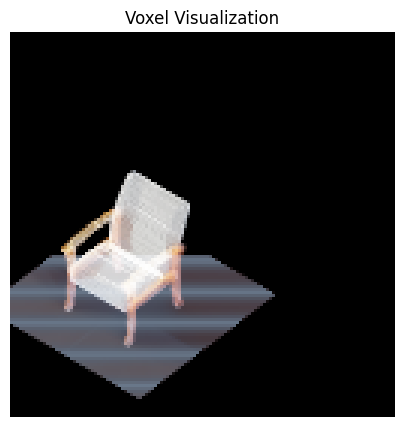

In [5]:
VOXEL_SIZE = 128
IMAGE_SIZE = 256

BLENDER_SCALE = 2
DIAMETER = 4.2  # The voxel area in world coordinates
GROUND_COLOR = np.array((136., 162, 199))/255.

object_rotation_v = object_rotation
object_translation_v = object_translation[:, 0, [1, 0, 2]]*BLENDER_SCALE
object_elevation_v = object_elevation

ground_occupancy = np.zeros((VOXEL_SIZE, VOXEL_SIZE, VOXEL_SIZE, 1),
                            dtype=np.float32)
ground_occupancy[-2, 1:-2, 1:-2, 0] = 1
ground_voxel_color = np.ones((VOXEL_SIZE, VOXEL_SIZE, VOXEL_SIZE, 3), 
                             dtype=np.float32)*\
                     np.array(GROUND_COLOR, dtype=np.float32)
ground_voxel_color = np.concatenate([ground_voxel_color, ground_occupancy],
                                    axis=-1)

scene_voxels = object_voxels*(1-ground_occupancy) + \
                ground_voxel_color*ground_occupancy

euler_angles_x = np.deg2rad(180-object_rotation_v)*np.array([1, 0, 0],
                                                            dtype=np.float32)
euler_angles_y = np.deg2rad(90-object_elevation_v)*np.array([0, 1, 0],
                                                            dtype=np.float32)
translation_vector = (object_translation_v/(DIAMETER*0.5))

interpolated_voxels = helpers.object_to_world(scene_voxels,
                                              euler_angles_x,
                                              euler_angles_y,
                                              translation_vector)

color_input, alpha_input = tf.split(interpolated_voxels, [3, 1], axis=-1)
voxel_img = visual_hull.render(color_input*alpha_input)

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(voxel_img[0])
ax.axis('off')
ax.set_title('Voxel Visualization')
plt.show()

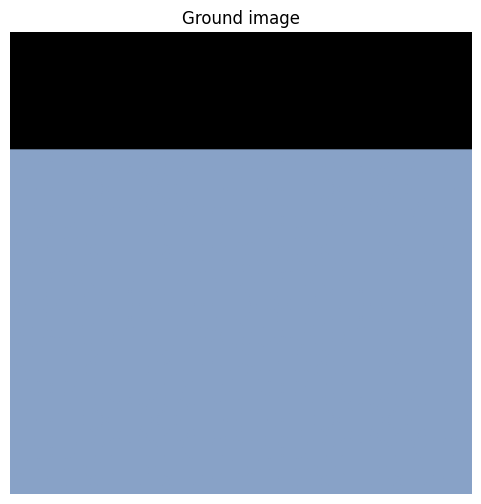

In [6]:
ground_image, ground_alpha = \
  helpers.generate_ground_image(IMAGE_SIZE, IMAGE_SIZE, focal, principal_point,
                                camera_rotation_matrix,
                                camera_translation_vector[:, :, 0],
                                GROUND_COLOR)

_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow((ground_image*ground_alpha)[0])
ax.axis('off')
ax.set_title('Ground image')
plt.show()

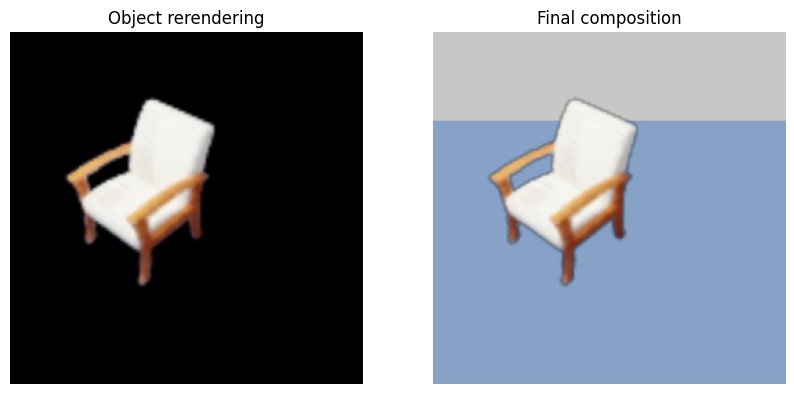

In [7]:
object_rotation_dvr = np.array(np.deg2rad(object_rotation),
                                dtype=np.float32)
object_translation_dvr = np.array(object_translation[..., [0, 2, 1]], 
                                  dtype=np.float32)
object_translation_dvr -= np.array([0, 0, helpers.OBJECT_BOTTOM],
                                    dtype=np.float32)

rerendering = \
  helpers.render_voxels_from_blender_camera(object_voxels,
                                    object_rotation_dvr,
                                    object_translation_dvr,
                                    256, 
                                    256,
                                    focal,
                                    principal_point,
                                    camera_rotation_matrix,
                                    camera_translation_vector,
                                    absorption_factor=1.0,
                                    cell_size=1.1,
                                    depth_min=3.0,
                                    depth_max=5.0,
                                    frustum_size=(128, 128, 128))
rerendering_image, rerendering_alpha = tf.split(rerendering, [3, 1], axis=-1)

rerendering_image = tf.image.resize(rerendering_image, (256, 256))
rerendering_alpha = tf.image.resize(rerendering_alpha, (256, 256))

BACKGROUND_COLOR = 0.784
final_composite = BACKGROUND_COLOR*(1-rerendering_alpha)*(1-ground_alpha) + \
                  ground_image*(1-rerendering_alpha)*ground_alpha + \
                  rerendering_image*rerendering_alpha

_, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(rerendering_image[0])
ax[0].axis('off')
ax[0].set_title('Object rerendering')
ax[1].imshow(final_composite[0])
ax[1].axis('off')
ax[1].set_title('Final composition')
plt.show()

In [8]:
# Downloading the data
!rm -rf /tmp/checkpoint
!mkdir /tmp/checkpoint
!wget -P /tmp/checkpoint https://storage.googleapis.com/tensorflow-graphics/notebooks/neural_voxel_renderer/model.ckpt-126650.data-00000-of-00001
!wget -P /tmp/checkpoint https://storage.googleapis.com/tensorflow-graphics/notebooks/neural_voxel_renderer/model.ckpt-126650.index
!wget -P /tmp/checkpoint https://storage.googleapis.com/tensorflow-graphics/notebooks/neural_voxel_renderer/model.ckpt-126650.meta

--2024-09-07 22:45:45--  https://storage.googleapis.com/tensorflow-graphics/notebooks/neural_voxel_renderer/model.ckpt-126650.data-00000-of-00001
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 947507856 (904M) [application/octet-stream]
Saving to: '/tmp/checkpoint/model.ckpt-126650.data-00000-of-00001'

model.ckpt-126650.d 100%[===================>] 903.61M  32.1MB/s    in 26s     

2024-09-07 22:46:11 (35.0 MB/s) - '/tmp/checkpoint/model.ckpt-126650.data-00000-of-00001' saved [947507856/947507856]

--2024-09-07 22:46:12--  https://storage.googleapis.com/tensorflow-graphics/notebooks/neural_voxel_renderer/model.ckpt-126650.index
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 108.177.127.207, 74.125.143.207, ...
Connecting to storage.googleapi

In [9]:
tf.compat.v1.reset_default_graph()

tf.compat.v1.set_random_seed(42)

g = tf.compat.v1.Graph()
with g.as_default():
  vol_placeholder = tf.compat.v1.placeholder(tf.float32, shape=[None, VOXEL_SIZE, VOXEL_SIZE, VOXEL_SIZE, 4],
                                             name='input_voxels')
    
  rerender_placeholder = tf.compat.v1.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, 3],
                                                  name='rerender')

  light_placeholder = tf.compat.v1.placeholder(tf.float32, shape=[None, 3],
                                               name='input_light')

In [10]:
latest_checkpoint = '/tmp/checkpoint/model.ckpt-126650'

model = models.neural_voxel_renderer_plus(None, None, None,
                                          VOXEL_SIZE,
                                          IMAGE_SIZE,
                                          size=3,
                                          norm2d='batchnorm', 
                                          norm3d='batchnorm')

# Prepare input data
a = interpolated_voxels.numpy()
b = final_composite.numpy() * 2. - 1
c = light_position

# Restore the checkpoint
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(latest_checkpoint).expect_partial()

# Run the computation
predictions = model.predict([a, b, c])

# predictions = (predictions - np.percentile(predictions, 25)) / (np.percentile(predictions, 75) - np.percentile(predictions, 25))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step


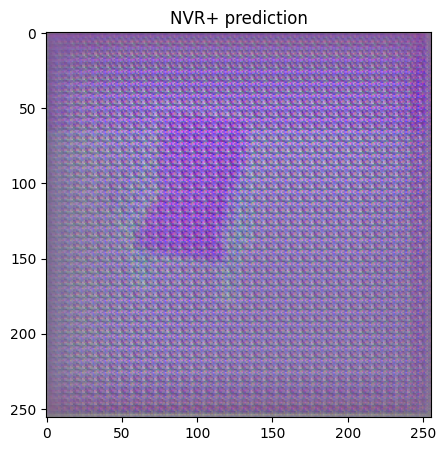

In [11]:
#@title NVR+ Output { vertical-output: true, run: "auto" }

view = 3 #@param {type:"slider", min:0, max:9, step:1}

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(predictions[view]*0.5+0.5, cmap='bone')
ax.axis('on')
ax.set_title('NVR+ prediction')
plt.show()